## Capstone Project : Building a Comprehensive Job Recommendation System

## Srimanth Madira - Data Science (M.S) - U01885136

## Import Statements

In [150]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

## Data Load

In [151]:
#Loading Data Using Pandas Library
data = pd.read_csv("dice_com-job_us_sample.csv")

In [152]:
data.head()

,advertiserurl,company,employmenttype_jobstatus,jobdescription,jobid,joblocation_address,jobtitle,postdate,shift,site_name,skills,uniq_id
0,https://www.dice.com/jobs/detail/AUTOMATION-TE...,"Digital Intelligence Systems, LLC","C2H Corp-To-Corp, C2H Independent, C2H W2, 3 M...",Looking for Selenium engineers...must have sol...,Dice Id : 10110693,"Atlanta, GA",AUTOMATION TEST ENGINEER,1 hour ago,Telecommuting not available|Travel not required,NaN,SEE BELOW,418ff92580b270ef4e7c14f0ddfc36b4
1,https://www.dice.com/jobs/detail/Information-S...,University of Chicago/IT Services,Full Time,The University of Chicago has a rapidly growin...,Dice Id : 10114469,"Chicago, IL",Information Security Engineer,1 week ago,Telecommuting not available|Travel not required,NaN,"linux/unix, network monitoring, incident respo...",8aec88cba08d53da65ab99cf20f6f9d9
2,https://www.dice.com/jobs/detail/Business-Solu...,"Galaxy Systems, Inc.",Full Time,"GalaxE.SolutionsEvery day, our solutions affec...",Dice Id : CXGALXYS,"Schaumburg, IL",Business Solutions Architect,2 weeks ago,Telecommuting not available|Travel not required,NaN,"Enterprise Solutions Architecture, business in...",46baa1f69ac07779274bcd90b85d9a72
3,https://www.dice.com/jobs/detail/Java-Develope...,TransTech LLC,Full Time,Java DeveloperFull-time/direct-hireBolingbrook...,Dice Id : 10113627,"Bolingbrook, IL","Java Developer (mid level)- FT- GREAT culture,...",2 weeks ago,Telecommuting not available|Travel not required,NaN,Please see job description,3941b2f206ae0f900c4fba4ac0b18719
4,https://www.dice.com/jobs/detail/DevOps-Engine...,Matrix Resources,Full Time,Midtown based high tech firm has an immediate ...,Dice Id : matrixga,"Atlanta, GA",DevOps Engineer,48 minutes ago,Telecommuting not available|Travel not required,NaN,"Configuration Management, Developer, Linux, Ma...",45efa1f6bc65acc32bbbb953a1ed13b7


## Data Cleaning, Standardization

In [153]:
data_info = data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   advertiserurl             22000 non-null  object
 1   company                   21950 non-null  object
 2   employmenttype_jobstatus  21770 non-null  object
 3   jobdescription            22000 non-null  object
 4   jobid                     22000 non-null  object
 5   joblocation_address       21997 non-null  object
 6   jobtitle                  22000 non-null  object
 7   postdate                  22000 non-null  object
 8   shift                     21643 non-null  object
 9   site_name                 3490 non-null   object
 10  skills                    21957 non-null  object
 11  uniq_id                   22000 non-null  object
dtypes: object(12)
memory usage: 2.0+ MB


### Missing Values Count 

In [154]:
#Checking for the Missing Values
data.isnull().sum()

advertiserurl                   0
company                        50
employmenttype_jobstatus      230
jobdescription                  0
jobid                           0
joblocation_address             3
jobtitle                        0
postdate                        0
shift                         357
site_name                   18510
skills                         43
uniq_id                         0
dtype: int64

In [155]:
#Dropping Unnecessary Columns
data_cleaned = data.drop(columns=['advertiserurl', 'jobid', 'postdate', 'site_name', 'uniq_id'])

data_cleaned.columns

Index(['company', 'employmenttype_jobstatus', 'jobdescription',
       'joblocation_address', 'jobtitle', 'shift', 'skills'],
      dtype='object')

In [156]:
data_cleaned.isnull().sum()

company                      50
employmenttype_jobstatus    230
jobdescription                0
joblocation_address           3
jobtitle                      0
shift                       357
skills                       43
dtype: int64

### Handling Missing Values

In [157]:
columns_to_impute = ['company', 'employmenttype_jobstatus', 'joblocation_address', 'shift']

for column in columns_to_impute:
    mode_value = data_cleaned[column].mode()[0]  
    data_cleaned[column].fillna(mode_value, inplace=True)  

### Skills Extraction & Cleaning

In [158]:
#Finding the number of unique Skills present over the entire dataset
skills_data = data_cleaned['skills'].dropna()

all_skills = skills_data.str.split(',|\s+').apply(lambda x: [skill.strip() for skill in x if skill.strip() != ''])

flattened_skills = [skill for sublist in all_skills for skill in sublist]

unique_skills = list(set(flattened_skills))

print("Unique skills found in the 'skills' column:")
print(len(unique_skills))

Unique skills found in the 'skills' column:
21168


In [159]:
#Code to remove unnecessary braces and parenthesis from the rows of skills
def clean_skill(skill):
    cleaned_skill = re.sub(r'[\(\)\[\]\{\}]', '', skill) 
    cleaned_skill = re.sub(r'\bAND\b', '', cleaned_skill, flags=re.IGNORECASE) 
    return cleaned_skill.strip()  

cleaned_skills = [clean_skill(skill) for skill in unique_skills]

In [160]:
#Function to extract the skills from the job description, where skills are missing
def extract_skills_from_description(description):
    found_skills = [skill for skill in cleaned_skills if re.search(r'\b' + re.escape(skill) + r'\b', description, re.IGNORECASE)]
    return ', '.join(found_skills) if found_skills else None

for index, row in data_cleaned[data_cleaned['skills'].isnull()].iterrows():
    extracted_skills = extract_skills_from_description(row['jobdescription'])
    if extracted_skills:
        data_cleaned.at[index, 'skills'] = extracted_skills  

print("Missing values in 'skills' after extraction:")
print(data_cleaned['skills'].isnull().sum())

Missing values in 'skills' after extraction:
0


In [161]:
data_cleaned[data_cleaned['skills'].isnull() == False].head()

,company,employmenttype_jobstatus,jobdescription,joblocation_address,jobtitle,shift,skills
0,"Digital Intelligence Systems, LLC","C2H Corp-To-Corp, C2H Independent, C2H W2, 3 M...",Looking for Selenium engineers...must have sol...,"Atlanta, GA",AUTOMATION TEST ENGINEER,Telecommuting not available|Travel not required,SEE BELOW
1,University of Chicago/IT Services,Full Time,The University of Chicago has a rapidly growin...,"Chicago, IL",Information Security Engineer,Telecommuting not available|Travel not required,"linux/unix, network monitoring, incident respo..."
2,"Galaxy Systems, Inc.",Full Time,"GalaxE.SolutionsEvery day, our solutions affec...","Schaumburg, IL",Business Solutions Architect,Telecommuting not available|Travel not required,"Enterprise Solutions Architecture, business in..."
3,TransTech LLC,Full Time,Java DeveloperFull-time/direct-hireBolingbrook...,"Bolingbrook, IL","Java Developer (mid level)- FT- GREAT culture,...",Telecommuting not available|Travel not required,Please see job description
4,Matrix Resources,Full Time,Midtown based high tech firm has an immediate ...,"Atlanta, GA",DevOps Engineer,Telecommuting not available|Travel not required,"Configuration Management, Developer, Linux, Ma..."


In [162]:
#Function to extract the skills from the description where ever skills are mentioned as see description below

description_rows = data_cleaned['skills'].str.contains(r'\b(?:description|below|null)\b', case=False, na=False)
data_cleaned.loc[description_rows, 'skills'] = ''

def extract_unique_skills(description):
    found_skills = [skill for skill in cleaned_skills if re.search(r'\b' + re.escape(skill) + r'\b', description, re.IGNORECASE)]
    return ', '.join(found_skills) if found_skills else ''  

for index, row in data_cleaned[description_rows].iterrows():
    extracted_skills = extract_unique_skills(row['jobdescription'])
    data_cleaned.at[index, 'skills'] = extracted_skills 

In [163]:
data_cleaned[['jobdescription', 'skills']].head()

,jobdescription,skills
0,Looking for Selenium engineers...must have sol...,"Hire, ON, SAP, WINDOWS, Groovy, must, SERVER, ..."
1,The University of Chicago has a rapidly growin...,"linux/unix, network monitoring, incident respo..."
2,"GalaxE.SolutionsEvery day, our solutions affec...","Enterprise Solutions Architecture, business in..."
3,Java DeveloperFull-time/direct-hireBolingbrook...,"ON, must, Benefits, SERVER, BENEFITS, Contact,..."
4,Midtown based high tech firm has an immediate ...,"Configuration Management, Developer, Linux, Ma..."


### Handling Categorial Variables City, State

In [164]:
#Splitting the address by delimeter and storing them in separate field as city, state
if data_cleaned['joblocation_address'].str.contains(',').any():
    split_address = data_cleaned['joblocation_address'].str.split(',', n=1, expand=True)
    data_cleaned['city'] = split_address[0].str.strip() 
    data_cleaned['state'] = split_address[1].str.strip() 

data_cleaned[['joblocation_address', 'city', 'state']].head()

,joblocation_address,city,state
0,"Atlanta, GA",Atlanta,GA
1,"Chicago, IL",Chicago,IL
2,"Schaumburg, IL",Schaumburg,IL
3,"Bolingbrook, IL",Bolingbrook,IL
4,"Atlanta, GA",Atlanta,GA


In [165]:
# Handling where only either city or state present 
count = 0
if not data_cleaned['joblocation_address'].str.contains(',').any():
    count = count + 1
    data_cleaned['city'] = None  # Set city to None
    data_cleaned['state'] = None  # Set state to None

In [166]:
no_comma_mask = ~data_cleaned['joblocation_address'].str.contains(',')

data_cleaned.loc[no_comma_mask, 'city'] = None
data_cleaned.loc[no_comma_mask, 'state'] = None


In [167]:
no_comma_mask = ~data_cleaned['joblocation_address'].str.contains(',')

data_cleaned.loc[no_comma_mask, 'city'] = None
data_cleaned.loc[no_comma_mask, 'state'] = None


for index in data_cleaned[no_comma_mask].index:
    address = data_cleaned.at[index, 'joblocation_address'].strip() 
    
    if len(address) == 2:
        data_cleaned.at[index, 'state'] = address  
    elif len(address) > 2:
        data_cleaned.at[index, 'city'] = address  

In [168]:
data_cleaned.head()

,company,employmenttype_jobstatus,jobdescription,joblocation_address,jobtitle,shift,skills,city,state
0,"Digital Intelligence Systems, LLC","C2H Corp-To-Corp, C2H Independent, C2H W2, 3 M...",Looking for Selenium engineers...must have sol...,"Atlanta, GA",AUTOMATION TEST ENGINEER,Telecommuting not available|Travel not required,"Hire, ON, SAP, WINDOWS, Groovy, must, SERVER, ...",Atlanta,GA
1,University of Chicago/IT Services,Full Time,The University of Chicago has a rapidly growin...,"Chicago, IL",Information Security Engineer,Telecommuting not available|Travel not required,"linux/unix, network monitoring, incident respo...",Chicago,IL
2,"Galaxy Systems, Inc.",Full Time,"GalaxE.SolutionsEvery day, our solutions affec...","Schaumburg, IL",Business Solutions Architect,Telecommuting not available|Travel not required,"Enterprise Solutions Architecture, business in...",Schaumburg,IL
3,TransTech LLC,Full Time,Java DeveloperFull-time/direct-hireBolingbrook...,"Bolingbrook, IL","Java Developer (mid level)- FT- GREAT culture,...",Telecommuting not available|Travel not required,"ON, must, Benefits, SERVER, BENEFITS, Contact,...",Bolingbrook,IL
4,Matrix Resources,Full Time,Midtown based high tech firm has an immediate ...,"Atlanta, GA",DevOps Engineer,Telecommuting not available|Travel not required,"Configuration Management, Developer, Linux, Ma...",Atlanta,GA


In [169]:
data_cleaned = data_cleaned.drop(columns=['joblocation_address'])

cols = ['company', 'employmenttype_jobstatus', 'jobdescription', 'city', 'state', 'jobtitle', 'shift', 'skills']
data_cleaned = data_cleaned[cols]

In [170]:
# Filtering rows where 'city' is missing
missing_city_rows = data_cleaned[data_cleaned['city'].isna()]

unique_states = missing_city_rows['state'].unique()

print("States where City is missing:")
print(unique_states)

States where City is missing:
['Co' 'Ca' 'Va' 'Dc' 'De' 'Md' 'Ny']


In [171]:
states_with_missing_city = ['Co', 'Ca', 'Va', 'Dc', 'De', 'Md', 'Ny']

state_city_mapping = {
    'Co': 'Denver',
    'Ca': 'Los Angeles',
    'Va': 'Richmond',
    'Dc': 'Washington',
    'De': 'Dover',
    'Md': 'Baltimore',
    'Ny': 'New York'
}

def fill_missing_city(row):
    if row['city'] is None and row['state'] in state_city_mapping:
        return state_city_mapping[row['state']]
    return row['city']

data_cleaned['city'] = data_cleaned.apply(fill_missing_city, axis=1)

In [172]:
# Identify unique city names where state is missing
unique_missing_state_cities = data_cleaned[data_cleaned['state'].isna()]['city'].unique()

unique_missing_state_cities_list = unique_missing_state_cities.tolist()

print(unique_missing_state_cities_list)

['Sacramento', 'Santa Clara', 'United States', 'Mexico City', 'Any City', 'Bangkok', 'Hyderabad', 'Bangalore', 'Brentwood', 'Peterborough', 'Sunnyvale', 'Phila', 'Toronto', 'Cherry Hill', 'Delhi', 'San Francisco', 'Beijing', 'Reading', 'Pune', 'San Isidro', 'St Petersburg', 'Mumbai', 'Konstanz', 'Chandigarh', 'Central', 'Guantanamo Bay', 'Guantanamo']


In [173]:
city_state_mapping = {
    
    'Sacramento': 'CA',
    'Santa Clara': 'CA',
    'United States': 'US',
    'Mexico City': 'MX',
    'Any City': "City",  
    'Bangkok': 'TH',
    'Hyderabad': 'IN',
    'Bangalore': 'IN',
    'Brentwood': 'CA',
    'Peterborough': 'ON',  
    'Sunnyvale': 'CA',
    'Phila': 'PA',
    'Toronto': 'ON', 
    'Cherry Hill': 'NJ',
    'Delhi': 'DL',  
    'San Francisco': 'CA',
    'Beijing': 'BJ',  
    'Reading': 'PA',
    'Pune': 'IN',
    'San Isidro': 'CA',
    'St Petersburg': 'FL',
    'Mumbai': 'MH',  
    'Konstanz': 'BW',  
    'Chandigarh': 'CH',  
    'Central': 'City',  
    'Guantanamo Bay': 'CU',  
    'Guantanamo': 'CU'  
}

# Function to fill missing states based on city
def fill_missing_state(row):
    if pd.isna(row['state']) and row['city'] in city_state_mapping:
        return city_state_mapping[row['city']]
    return row['state']

# Apply the function to update the DataFrame
data_cleaned['state'] = data_cleaned.apply(fill_missing_state, axis=1)

In [174]:
data_cleaned.isnull().sum()

company                     0
employmenttype_jobstatus    0
jobdescription              0
city                        0
state                       0
jobtitle                    0
shift                       0
skills                      0
dtype: int64

## Exploratory Data Analysis

### States by Job Postings

In [175]:
state_job_counts = data_cleaned['state'].value_counts()

top_5_states = state_job_counts.head(5)

print(top_5_states)

state
CA    4623
NY    2213
GA    1925
TX    1924
NJ    1820
Name: count, dtype: int64


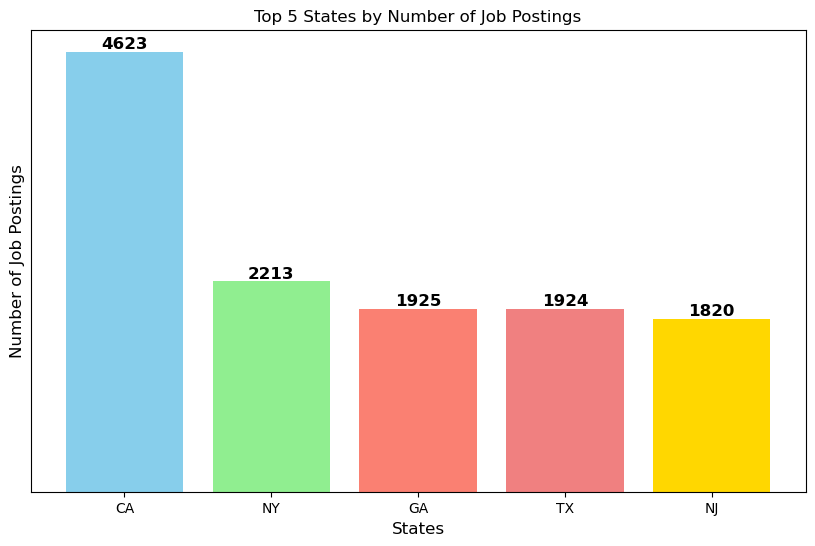

In [176]:
top_states = data_cleaned['state'].value_counts().nlargest(5)

colors = ['skyblue', 'lightgreen', 'salmon', 'lightcoral', 'gold']
plt.figure(figsize=(10,6))
bars = plt.bar(top_states.index, top_states.values, color=colors)

plt.xlabel('States', fontsize=12)
plt.ylabel('Number of Job Postings', fontsize=12)
plt.title('Top 5 States by Number of Job Postings', fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.yticks([])

plt.show()

### Top Cities by Job Counts 

In [177]:
city_job_counts = data_cleaned['city'].value_counts()

top_7_cities = city_job_counts.head(7)

print(top_7_cities)

city
New York         1373
Atlanta          1245
San Francisco     889
Seattle           661
Boston            608
Houston           536
San Jose          452
Name: count, dtype: int64


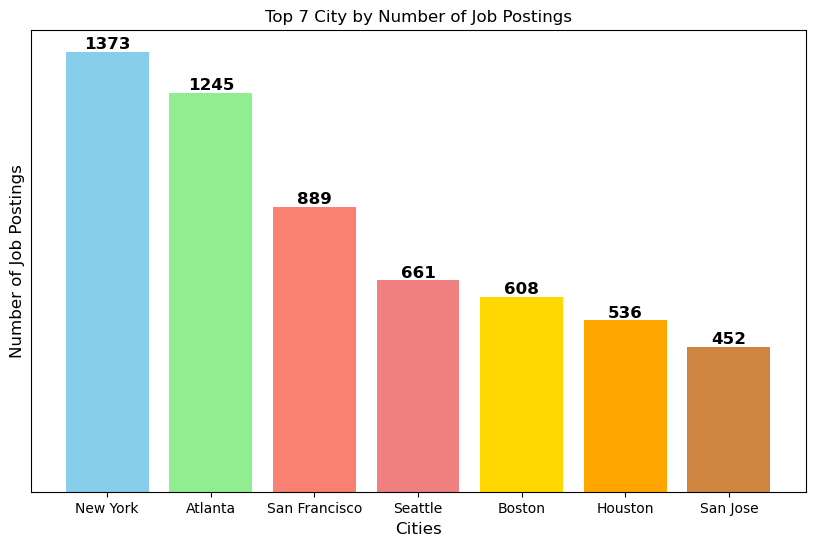

In [178]:
top_cities = data_cleaned['city'].value_counts().nlargest(7)

colors = ['skyblue', 'lightgreen', 'salmon', 'lightcoral', 'gold', 'orange', 'peru']
plt.figure(figsize=(10,6))
bars = plt.bar(top_cities.index, top_cities.values, color=colors)

plt.xlabel('Cities', fontsize=12)
plt.ylabel('Number of Job Postings', fontsize=12)
plt.title('Top 7 City by Number of Job Postings', fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.yticks([])

plt.show()

### Relation between City & Job Title

    city state                      jobtitle  count
 Atlanta    GA                Java Developer     13
New York    NY Software Development Engineer     11
 Atlanta    GA         Senior Java Developer     10
New York    NY               Project Manager     10
 Atlanta    GA              Business Analyst      9
New York    NY              Business Analyst      9
New York    NY                Java Developer      9
 Seattle    WA Software Development Engineer      8
 Atlanta    GA            Backbase Developer      8
New York    NY             Software Engineer      8


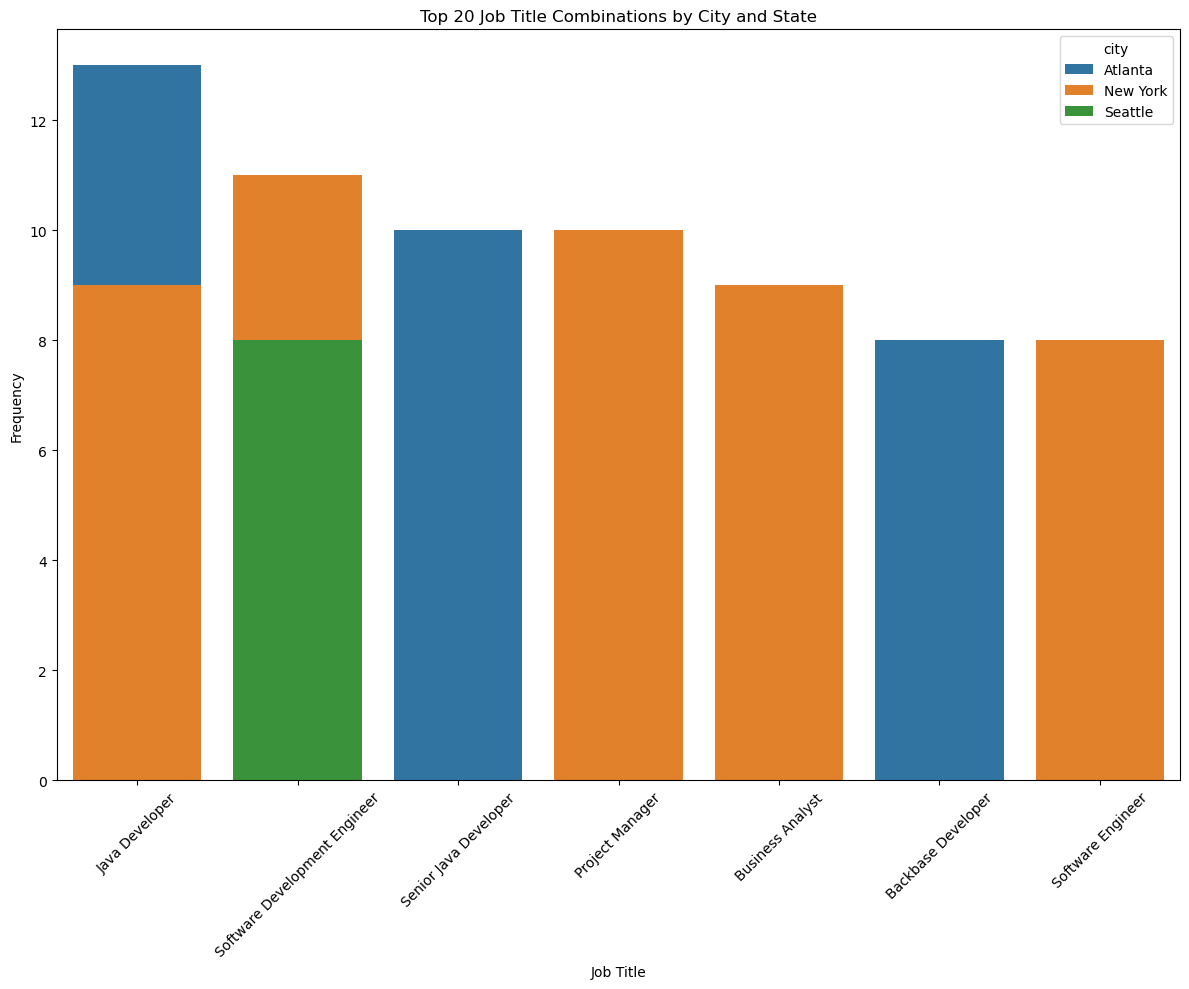

In [179]:
# Group by city, state, and job title to find the frequency of each combination
grouped_data = data_cleaned.groupby(['city', 'state', 'jobtitle']).size().reset_index(name='count')

top_combinations = grouped_data.sort_values(by='count', ascending=False).head(10)

print(top_combinations.to_string(index=False))

plt.figure(figsize=(12, 10))
sns.barplot(x='jobtitle', y='count', hue='city', data=top_combinations, dodge=False)

plt.xlabel('Job Title')
plt.ylabel('Frequency')
plt.title('Top 20 Job Title Combinations by City and State')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Full Time Employment vs Part Time Employment

In [180]:
# Counting the total number of jobs
total_jobs = len(data_cleaned)

full_time_jobs = data_cleaned['employmenttype_jobstatus'].str.contains('Full Time', case=False, na=False).sum()

non_full_time_jobs = total_jobs - full_time_jobs

full_time_percentage = (full_time_jobs / total_jobs) * 100
non_full_time_percentage = (non_full_time_jobs / total_jobs) * 100

print(f"Percentage of Full Time jobs: {full_time_percentage:.2f}%")
print(f"Percentage of Non-Full Time jobs: {non_full_time_percentage:.2f}%")

Percentage of Full Time jobs: 57.75%
Percentage of Non-Full Time jobs: 42.25%


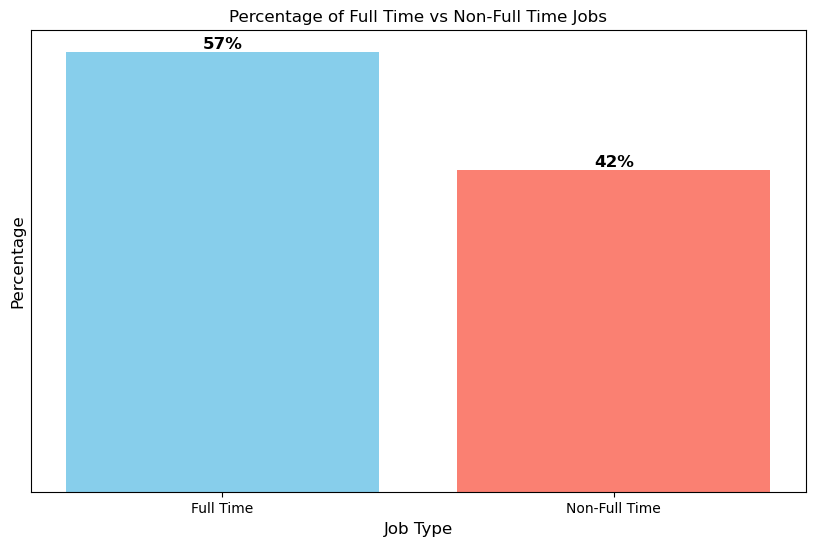

In [181]:
job_types = ['Full Time', 'Non-Full Time']
percentages = [full_time_percentage, non_full_time_percentage]

colors = ['skyblue', 'salmon']

plt.figure(figsize=(10,6))
bars = plt.bar(job_types, percentages, color=colors)

plt.xlabel('Job Type', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('Percentage of Full Time vs Non-Full Time Jobs', fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}%', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.yticks([])

plt.show()

### Top SKills in the Market

In [182]:
# Finding the top skills in the present market
skills_copy = data_cleaned['skills'].copy()

skills_copy = skills_copy.str.split(',')

all_skills = skills_copy.explode().str.strip()

all_skills = all_skills[all_skills != '']

skill_counts = Counter(all_skills)

skills_df = pd.DataFrame(skill_counts.items(), columns=['Skill', 'Count'])

n = 10 

top_skills = skills_df.nlargest(n, 'Count')

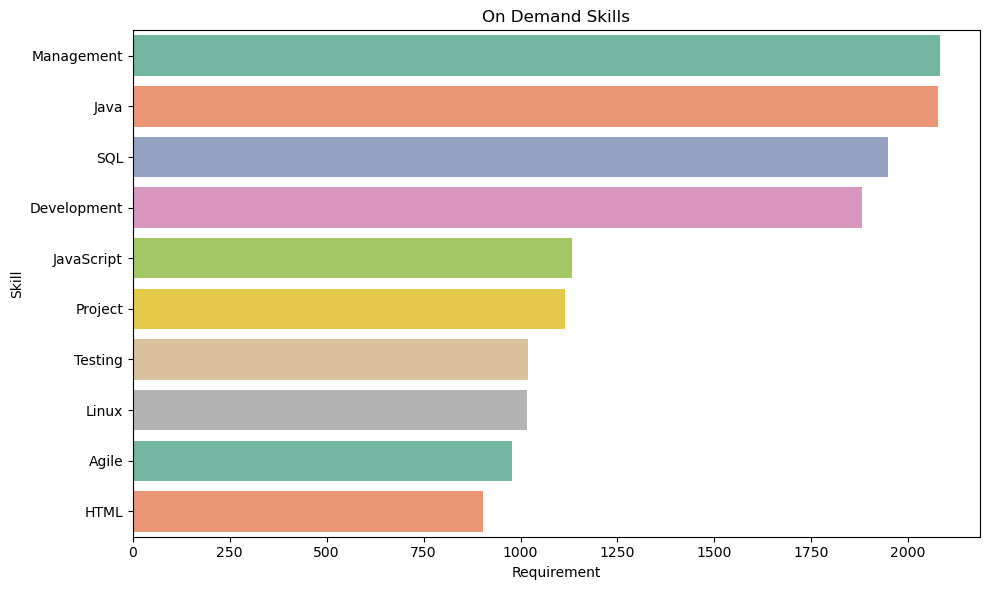

In [187]:
plt.figure(figsize=(10, 6))

sns.barplot(x='Count', y='Skill', data=top_skills, palette='Set2')

plt.xlabel('Requirement')
plt.ylabel('Skill')
plt.title('On Demand Skills')

plt.tight_layout()
plt.show()

### Job Roles On Demand

In [189]:
jobtitle_counts = data_cleaned['jobtitle'].value_counts()

jobtitle_counts_df = jobtitle_counts.reset_index()
jobtitle_counts_df.columns = ['Job Title', 'Count']

most_common_jobtitles = jobtitle_counts_df.nlargest(10, 'Count')

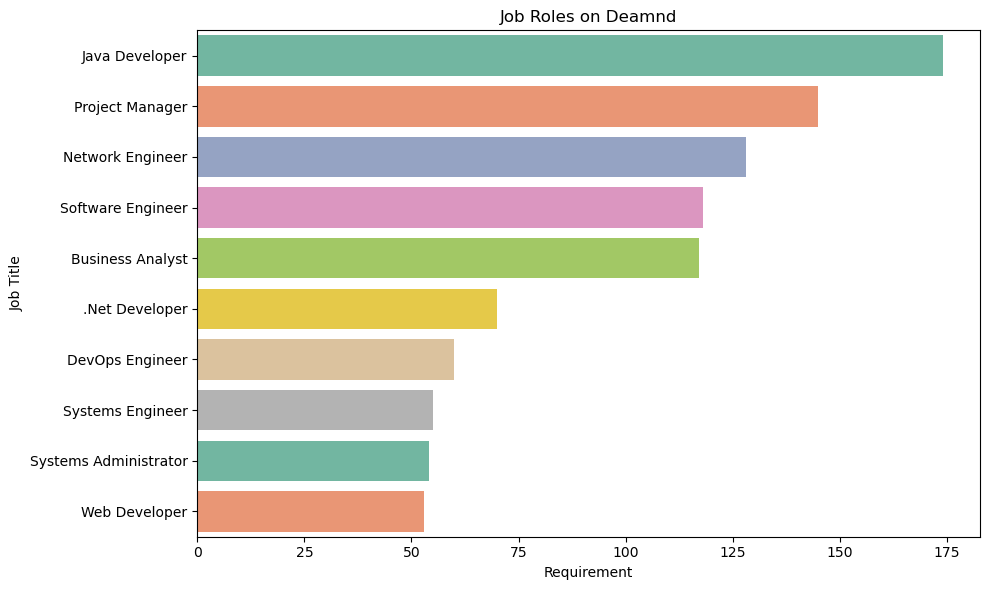

In [192]:
most_common_jobtitles = most_common_jobtitles.reset_index() 

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Job Title', data=most_common_jobtitles, palette='Set2')

plt.title('Job Roles on Deamnd')
plt.xlabel('Requirement')
plt.ylabel('Job Title')

plt.tight_layout()
plt.show()

## Storing Data into a CSV File

In [184]:
data_cleaned.to_csv('cleaned_skills_data.csv', index=False)

In [185]:
data_cleaned.head()

,company,employmenttype_jobstatus,jobdescription,city,state,jobtitle,shift,skills
0,"Digital Intelligence Systems, LLC","C2H Corp-To-Corp, C2H Independent, C2H W2, 3 M...",Looking for Selenium engineers...must have sol...,Atlanta,GA,AUTOMATION TEST ENGINEER,Telecommuting not available|Travel not required,"Hire, ON, SAP, WINDOWS, Groovy, must, SERVER, ..."
1,University of Chicago/IT Services,Full Time,The University of Chicago has a rapidly growin...,Chicago,IL,Information Security Engineer,Telecommuting not available|Travel not required,"linux/unix, network monitoring, incident respo..."
2,"Galaxy Systems, Inc.",Full Time,"GalaxE.SolutionsEvery day, our solutions affec...",Schaumburg,IL,Business Solutions Architect,Telecommuting not available|Travel not required,"Enterprise Solutions Architecture, business in..."
3,TransTech LLC,Full Time,Java DeveloperFull-time/direct-hireBolingbrook...,Bolingbrook,IL,"Java Developer (mid level)- FT- GREAT culture,...",Telecommuting not available|Travel not required,"ON, must, Benefits, SERVER, BENEFITS, Contact,..."
4,Matrix Resources,Full Time,Midtown based high tech firm has an immediate ...,Atlanta,GA,DevOps Engineer,Telecommuting not available|Travel not required,"Configuration Management, Developer, Linux, Ma..."
